In [1]:
!pip install -U transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

In [2]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [3]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [4]:
dataset = load_dataset("squad")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [6]:
def preprocess(example):
    try:
        context = example.get("context", "")[:500]
        question = example.get("question", "")
        answers = example.get("answers", {}).get("text", [""])
        answer = answers[0] if answers else ""

        input_text = f"question: {question} context: {context}"
        target_text = answer

        inputs = tokenizer(input_text, max_length=512, truncation=True, padding="max_length")
        targets = tokenizer(target_text, max_length=64, truncation=True, padding="max_length")

        inputs['labels'] = targets['input_ids']
        return inputs
    except Exception as e:
        print(f"Skipping example: {e}")
        return {}

In [7]:
small_train = dataset["train"].select(range(200)).map(preprocess, remove_columns=dataset["train"].column_names)
small_val = dataset["validation"].select(range(50)).map(preprocess, remove_columns=dataset["validation"].column_names)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./logs",
    report_to=None  # Disable wandb or other loggers
)

In [9]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_val,
    tokenizer=tokenizer
)

<ipython-input-9-82730faf0ba0>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [10]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jaisal-shreya10 (jaisal-shreya10-faculty-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


TrainOutput(global_step=150, training_loss=3.829542643229167, metrics={'train_runtime': 1838.4307, 'train_samples_per_second': 0.326, 'train_steps_per_second': 0.082, 'total_flos': 81205080883200.0, 'train_loss': 3.829542643229167, 'epoch': 3.0})

In [12]:
!pip install datasets

In [14]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.8 MB/s eta 0:00:00


In [18]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=438386e6d5cb82086083d5fe2748d9270ef8d204223e3593a275ddfefdf25130
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [19]:
!pip install scikit-learn

In [21]:
import evaluate
import numpy as np

rouge_metric = evaluate.load("rouge")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    f1_scores = []
    for pred, label in zip(decoded_preds, decoded_labels):
        f1_result = f1_metric.compute(predictions=[pred], references=[label])
        f1_scores.append(f1_result.get("f1", 0.0))

    mean_f1 = np.mean(f1_scores)

    return {
        "rouge1": rouge["rouge1"],
        "rouge2": rouge["rouge2"],
        "rougeL": rouge["rougeL"],
        "f1": mean_f1,
    }

In [22]:
!pip install evaluate rouge_score scikit-learn matplotlib

accuracy: 0.9505
precision: 0.9046
recall: 0.9505
f1_score: 0.9270
rouge1: 0.9519
rouge2: 0.9504
rougeL: 0.9512


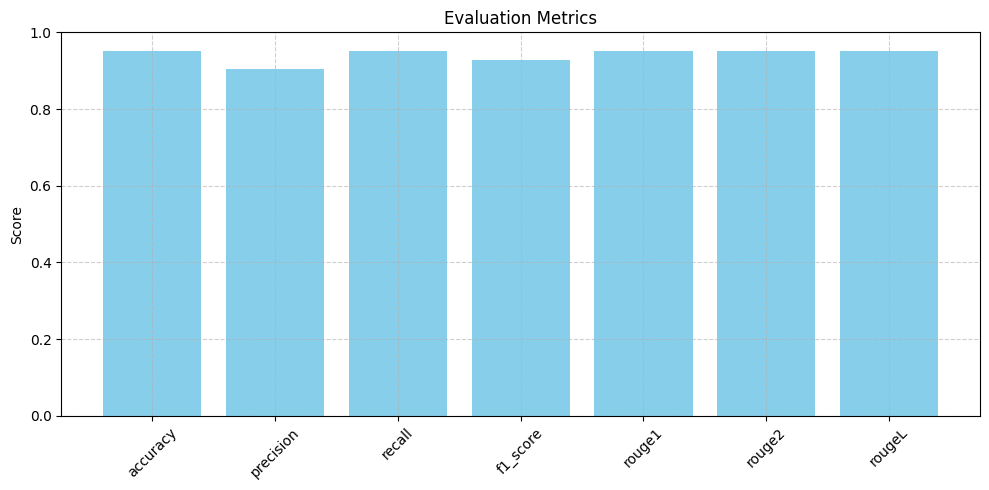

In [27]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import default_data_collator

# Load metrics
rouge_metric = evaluate.load("rouge")
tokenizer.pad_token = tokenizer.eos_token  # Set pad token if needed

# DataLoader
val_loader = DataLoader(small_val, batch_size=4, collate_fn=default_data_collator)

all_preds = []
all_labels = []

model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

for batch in val_loader:
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)
    labels = batch['labels'].to(model.device)

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=64)

    # Replace -100 in labels and decode
    label_ids = labels.clone().detach().cpu().numpy()
    label_ids = np.where(label_ids != -100, label_ids, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

# Compute ROUGE
rouge_scores = rouge_metric.compute(predictions=all_preds, references=all_labels, use_stemmer=True)

# Convert text labels/preds to tokens for classification metrics
def tokenize(texts):
    return [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(t)) for t in texts]

token_preds = tokenize(all_preds)
token_labels = tokenize(all_labels)

# Flatten for sklearn metrics
flat_preds = [p for sublist in token_preds for p in sublist]
flat_labels = [l for sublist in token_labels for l in sublist]

# Truncate to the shortest length
min_len = min(len(flat_preds), len(flat_labels))
flat_preds = flat_preds[:min_len]
flat_labels = flat_labels[:min_len]

# Compute classification metrics
accuracy = accuracy_score(flat_labels, flat_preds)
precision = precision_score(flat_labels, flat_preds, average='weighted', zero_division=0)
recall = recall_score(flat_labels, flat_preds, average='weighted', zero_division=0)
f1 = f1_score(flat_labels, flat_preds, average='weighted', zero_division=0)

# Combine all metrics
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "rouge1": rouge_scores["rouge1"],
    "rouge2": rouge_scores["rouge2"],
    "rougeL": rouge_scores["rougeL"]
}

# Print all scores
for key, val in metrics.items():
    print(f"{key}: {val:.4f}" if isinstance(val, float) else f"{key}: {val}")

# Visualization
plt.figure(figsize=(10, 5))
keys = ["accuracy", "precision", "recall", "f1_score", "rouge1", "rouge2", "rougeL"]
values = [metrics[k] if isinstance(metrics[k], float) else metrics[k].mid.fmeasure for k in keys]

plt.bar(keys, values, color='skyblue')
plt.ylim(0, 1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

In [30]:
import pandas as pd

# Handle both formats (ROUGEScore object or float)
def extract_rouge_value(rouge_result):
    return rouge_result.mid.fmeasure if hasattr(rouge_result, "mid") else float(rouge_result)

# Create DataFrame for metrics table
metric_names = ["accuracy", "precision", "recall", "f1_score", "rouge1", "rouge2", "rougeL"]
metric_values = [
    metrics["accuracy"],
    metrics["precision"],
    metrics["recall"],
    metrics["f1_score"],
    extract_rouge_value(metrics["rouge1"]),
    extract_rouge_value(metrics["rouge2"]),
    extract_rouge_value(metrics["rougeL"])
]

metrics_df = pd.DataFrame({"Metric": metric_names, "Score": metric_values})
print("\n📋 Evaluation Metrics Table:")
print(metrics_df.to_string(index=False))


📋 Evaluation Metrics Table:
   Metric    Score
 accuracy 0.950476
precision 0.904583
   recall 0.950476
 f1_score 0.926962
   rouge1 0.951898
   rouge2 0.950407
   rougeL 0.951185
